# HW2P2: Face Classification and Verification


Congrats on coming to the second homework in 11785: Introduction to Deep Learning. This homework significantly longer and tougher than the previous homework. You have 2 sub-parts as outlined below. Please start early!


*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# Preliminaries

In [1]:
!nvidia-smi # to see what GPU you have

Thu Oct 19 11:09:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8              21W /  80W |   1511MiB /  8192MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install wandb --quiet
!pip install ipdb --quiet

In [3]:
import torch
import torch.nn.init as init
from torchsummary import summary
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Device:  cuda


In [4]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

ModuleNotFoundError: No module named 'google.colab'

In [7]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"sushanthjayanth","key":""}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

Defaulting to user installation because normal site-packages is not writeable
  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


PermissionError: [Errno 13] Permission denied: '/root/.kaggle/kaggle.json'

# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data from Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2

In [ ]:
!mkdir '/content/data'

!kaggle competitions download -c 11-785-f23-hw2p2-classification
!unzip -qo '11-785-f23-hw2p2-classification.zip' -d '/content/data'

mkdir: cannot create directory ‘/content/data’: File exists
11-785-f23-hw2p2-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


# Check the Dataset to see image shapes

In [4]:
DATA_DIR    = '/content/data/11-785-f23-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

In [5]:
from torchvision.datasets import ImageFolder

val_dataset = ImageFolder(VAL_DIR, transform=transforms.ToTensor())

i = 0
for img, label in val_dataset:
    print(img.shape)
    print(label)
    i = i + 1

    if i > 3:
      break

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/11-785-f23-hw2p2-classification/dev'

## Find the Mean and Std Dev

In [6]:
def get_mean_and_std(IMAGE_DATA_DIR):
    train_dataset = ImageFolder(IMAGE_DATA_DIR, transform=transforms.ToTensor())

    # Initialize lists to store channel-wise means and standard deviations
    channel_wise_means = [0.0, 0.0, 0.0]
    channel_wise_stds = [0.0, 0.0, 0.0]

    # Iterate through the training dataset to calculate means and standard deviations
    for image, _ in train_dataset:
        for i in range(3):  # Assuming RGB images
            channel_wise_means[i] += image[i, :, :].mean().item()
            channel_wise_stds[i] += image[i, :, :].std().item()

    # Calculate the mean and standard deviation for each channel
    num_samples = len(train_dataset)
    channel_wise_means = [mean / num_samples for mean in channel_wise_means]
    channel_wise_stds = [std / num_samples for std in channel_wise_stds]

    # Print the mean and standard deviation for each channel
    print("Mean:", channel_wise_means)
    print("Std:", channel_wise_stds)

    return channel_wise_means, channel_wise_stds

# Configs

In [7]:
config = {
    'batch_size': 256, # Increase this if your GPU can handle it
    'lr': 4e-3,
    'epochs': 20, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
    'truncated_normal_mean' : 0,
    'truncated_normal_std' : 0.2,
}

# Classification Dataset

In [ ]:
DATA_DIR    = '/content/data/11-785-f23-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html

# Means and standard dev found using disabled function above
channel_wise_means = [0.5102565238565329, 0.4014372720903177, 0.35085473649373455]
channel_wise_stds = [0.27081365674401414, 0.2362703534933915, 0.22260160982063917]

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.ColorJitter(brightness=0.16, contrast=0.15, saturation=0.1),
    torchvision.transforms.RandomRotation(18),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    torchvision.transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=channel_wise_means, std=channel_wise_stds),
    torchvision.transforms.RandomErasing(p=0.3, scale=(0.05, 0.1)),
])# Implementing the right train transforms/augmentation methods is key to improving performance.

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=channel_wise_means, std=channel_wise_stds),
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform=valid_transforms)
# You should NOT have data augmentation on the validation set. Why?


# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

Mean: [0.5102565238565329, 0.4014372720903177, 0.35085473649373455]
Std: [0.27081365674401414, 0.2362703534933915, 0.22260160982063917]
Mean: [0.5105646841101367, 0.40180120049697654, 0.3509469015680231]
Std: [0.2708615781599942, 0.23630113799056846, 0.22264203338082594]


In [ ]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [ ]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 2)

In [4]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

NameError: name 'train_dataset' is not defined

## Data visualization

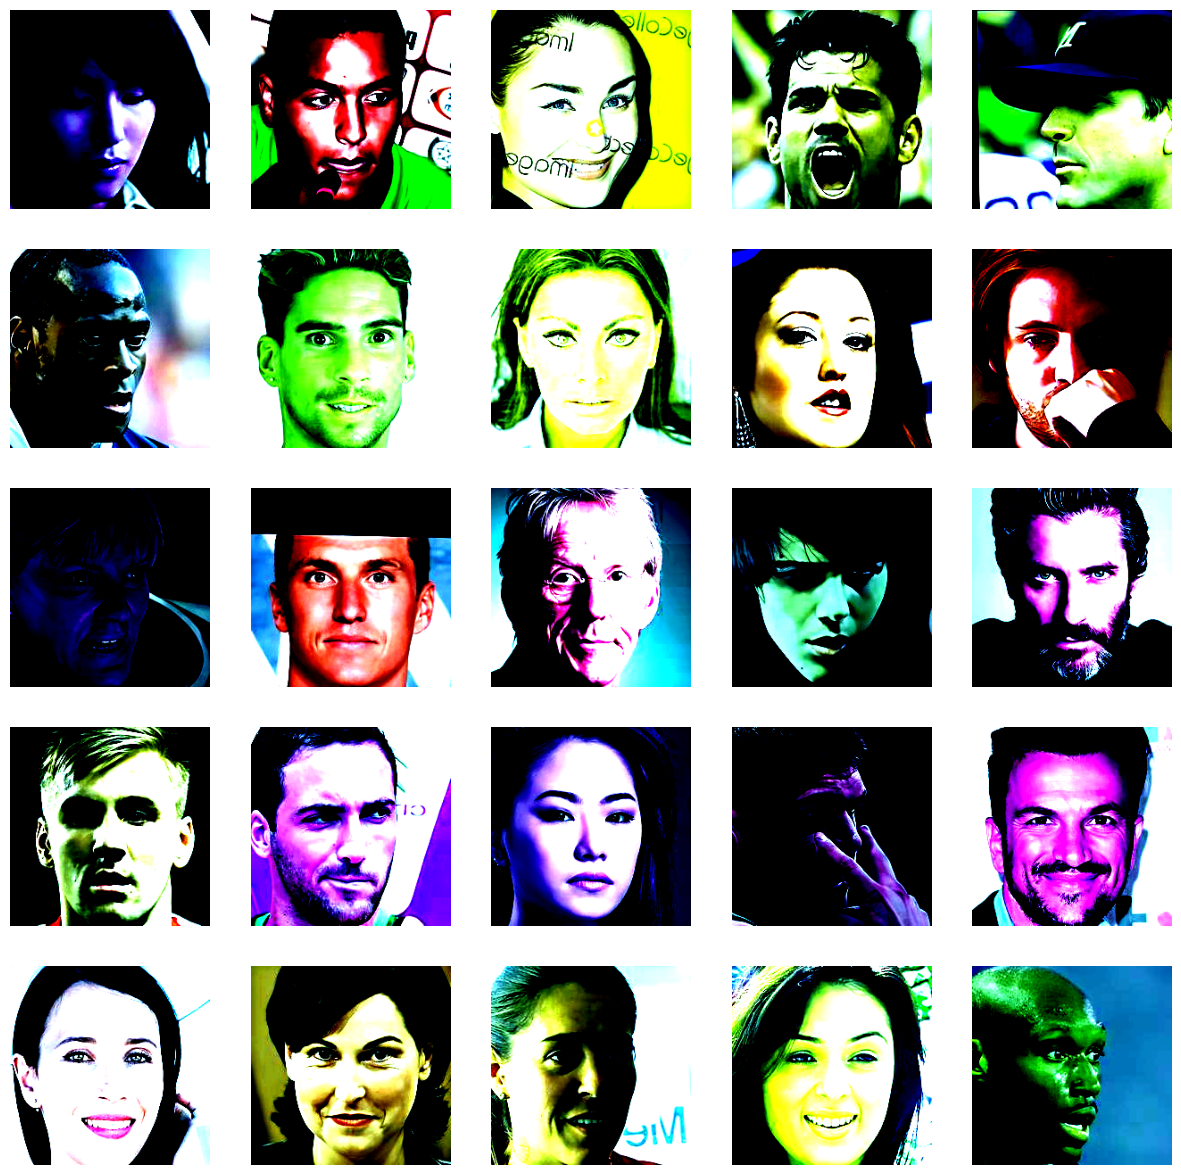

In [ ]:
# Visualize a few images in the dataset
# You can write your own code, and you don't need to understand the code
# It is highly recommended that you visualize your data augmentation as sanity check

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True,
)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Very Simple Network (for Mandatory Early Submission)

In [8]:
class LayerNorm(torch.nn.Module):
    """
    Using only channel_last method which is implemented in torch's layer_norm
    """
    def __init__(self, normalized_shape, eps=1e-6, channels="first"):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.ones(normalized_shape))
        self.bias = torch.nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.normalized_shape = (normalized_shape, )
        self.channels = channels

    def forward(self, x):
        if self.channels == "last":
            """
            To use inbuilt layer_norm we permute from
            (batch_size, channels, height, width) -> (batch_size, height, width, channels)
            """
            return torch.nn.functional.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.channels == "first":
            ######### REIMPLEMENT THIS YOURSELF ######
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

In [9]:
class DropPath(torch.nn.Module):
    """
    Stochastic Depth (we drop the non-shortcut path inside residual blocks with
                      some probability p)
    """

    def __init__(self, drop_probability = 0.0):
        super().__init__()
        self.drop_prob = drop_probability

    def forward(self, x):
        # if drop prob is zero or in inference mode, skip this
        if np.isclose(self.drop_prob, 0.0, atol=1e-9) or not self.training:
          return x

        # find output shape (eg. if input = 4D tensor, output = (1,1,1,1))
        # output_shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        output_shape = (x.shape[0],1,1,1)

        # create mask of output shape and of input type on same device
        keep_mask = torch.empty(output_shape, dtype=x.dtype, device=DEVICE).bernoulli_((1-self.drop_prob))
        # Alternative: random_tensor = x.new_empty(shape).bernoulli_(keep_prob)

        # NOTE: all methods like bernoulli_ with the underscore suffix means they
        # are inplace operations
        keep_mask.div_((1-self.drop_prob))

        return x*keep_mask

In [10]:
class ConvNextBlock(torch.nn.Module):
    """
    Refer : https://browse.arxiv.org/pdf/2201.03545v2.pdf for detailed architechture

    """

    def __init__(self, num_ch, expansion_factor, drop_prob=0.0):
        # num_ch = number of channels at first and third layer of block
        # There'll be an expansion in the second layer given by expansion_factor
        super().__init__()

        """
        NOTE: To perform depthwise conv we use the param (groups=num_ch)
        to create a separate filter for each input channel
        """


        self.main_block = torch.nn.Sequential(
            # 1st conv layer (deptwise)
            torch.nn.Conv2d(in_channels=num_ch, out_channels=num_ch,
                            kernel_size=7, padding=3, groups=num_ch),
            torch.nn.BatchNorm2d(num_ch),

            # 2nd conv layer
            torch.nn.Conv2d(in_channels=num_ch, out_channels=num_ch*expansion_factor, kernel_size=1, stride=1), # 1x1 pointwise convs implemented as Linear Layer
            torch.nn.GELU(),

            # 3rd conv layer
            torch.nn.Conv2d(in_channels=num_ch*expansion_factor, out_channels=num_ch, kernel_size=1, stride=1)
        )

        for layer in self.main_block:
            if isinstance(layer, torch.nn.Conv2d):
                init.trunc_normal_(layer.weight, mean=config['truncated_normal_mean'], std=config['truncated_normal_std'])
                init.constant_(layer.bias, 0)

        # define the drop_path layer
        if drop_prob > 0.0:
            self.drop_residual_path = DropPath(drop_prob)
        else:
            self.drop_residual_path = torch.nn.Identity()

    def forward(self, x):
        input = x.clone()
        x = self.main_block(x)

        # sum the main and shortcut connection
        x = input + self.drop_residual_path(x)

        return x

In [11]:
class Network(torch.nn.Module):
    """
    ConvNext
    """

    def __init__(self, num_classes=7001, drop_rate=0.5, expand_factor=4):
        super().__init__()

        self.backbone_out_channels = 400
        self.num_classes = num_classes

        # number of channels at input/output of each res_blocks
        self.channel_list = [50, 175, 250, 400]
        # self.channel_list = [96, 192, 384, 768]

        # number of repeats for each res_block
        self.block_repeat_list = [6,5,4,4]
        # self.block_repeat_list = [3,3,9,3]

        # define number of stages from above
        self.num_stages = len(self.block_repeat_list)

        self.drop_path_probabilities = [i.item() for i in torch.linspace(0, drop_rate, sum(self.channel_list))]

        ############## DEFINE RES BLOCK AND AUX LAYERS ########################

        # # Define the Stem (the first layer which takes input images)
        self.stem = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=self.channel_list[0], kernel_size=4, stride=4),
            torch.nn.BatchNorm2d(self.channel_list[0]),
            )

        # truncated normal initialization
        for layer in self.stem:
            if isinstance(layer, torch.nn.Conv2d):
                init.trunc_normal_(layer.weight, mean=config['truncated_normal_mean'], std=config['truncated_normal_std'])
                init.constant_(layer.bias, 0)

        # # Store the LayerNorm and Downsampling layer when switching btw 2 types of res_blocks
        # self.block_to_block_ln_and_downsample = []
        self.block_to_block_ln_and_downsample = [self.stem]
        for i in range(self.num_stages - 1):
            inter_downsample = torch.nn.Sequential(
                    torch.nn.BatchNorm2d(self.channel_list[i]),
                    torch.nn.Conv2d(in_channels=self.channel_list[i],
                                    out_channels=self.channel_list[i+1],
                                    kernel_size=2, stride=2)
                  )
            self.block_to_block_ln_and_downsample.append(inter_downsample)

        # Store the Res_block stages (eg. 3xres_2, 3xres_3, ...)
        self.res_block_stages = torch.nn.ModuleList()
        for i in range(self.num_stages):
            res_block_layer = []
            for j in range(self.block_repeat_list[i]):
                res_block_layer.append(ConvNextBlock(num_ch=self.channel_list[i],
                                  expansion_factor=expand_factor,
                                  drop_prob=self.drop_path_probabilities[i+j]))

            # append the repeated res_blocks as one layer
            # *res_block_layer means we add individual elements of the res_block_layer list
            self.res_block_stages.append(torch.nn.Sequential(*res_block_layer))

        # truncated normal initialization
        for res_block_stage in self.res_block_stages:
            for layer in res_block_stage:
                if isinstance(layer, torch.nn.Conv2d):
                    init.trunc_normal_(layer.weight, mean=config['truncated_normal_mean'], std=config['truncated_normal_std'])
                    init.constant_(layer.bias, 0)

        # # final norm layer (here we use torch's own)
        # self.final_norm = torch.nn.LayerNorm(self.channel_list[-1], eps=1e-6)

        # # final pool layer
        # self.final_pool = torch.nn.AdaptiveAvgPool2d((1,1))

        #####################################################################

        self.backbone = torch.nn.Sequential(
              # essentially stem (replace with stem if it works)
              self.block_to_block_ln_and_downsample[0],
              # res_1 block
              self.res_block_stages[0],
              self.block_to_block_ln_and_downsample[1],
              # res_2 block
              self.res_block_stages[1],
              self.block_to_block_ln_and_downsample[2],
              # res_3 block
              self.res_block_stages[2],
              self.block_to_block_ln_and_downsample[3],
              # res_4 block
              self.res_block_stages[3],
              torch.nn.AdaptiveAvgPool2d((1,1)),
              torch.nn.Flatten(),
            )

        self.cls_layer = torch.nn.Sequential(
            torch.nn.Linear(self.backbone_out_channels, self.num_classes))

        # truncated normal initialization
        for layer in self.cls_layer:
            if isinstance(layer, torch.nn.Linear):
                init.trunc_normal_(layer.weight, mean=config['truncated_normal_mean'], std=config['truncated_normal_std'])
                init.constant_(layer.bias, 0)

    def forward(self, x, return_feats=False):
        """
        What is return_feats? It essentially returns the second-to-last-layer
        features of a given image. It's a "feature encoding" of the input image,
        and you can use it for the verification task. You would use the outputs
        of the final classification layer for the classification task.

        You might also find that the classification outputs are sometimes better
        for verification too - try both.
        """
        feats = self.backbone(x)
        out = self.cls_layer(feats)

        if return_feats:
            return feats
        else:
            return out

model = Network().to(DEVICE)
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 400]                 --
├─Sequential: 1-2                        [-1, 50, 56, 56]          --
├─Sequential: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 50, 56, 56]          (recursive)
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 50, 56, 56]          2,450
├─Sequential: 1                          []                        --
|    └─Sequential: 2                     []                        --
|    |    └─Conv2d: 3-1                  [-1, 50, 56, 56]          (recursive)
├─Sequential: 1                          []                        --
|    └─BatchNorm2d: 2-3                  [-1, 50, 56, 56]          100
├─Sequential: 1                          []                        --
|    └─Sequential: 2                     []                    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 400]                 --
├─Sequential: 1-2                        [-1, 50, 56, 56]          --
├─Sequential: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 50, 56, 56]          (recursive)
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 50, 56, 56]          2,450
├─Sequential: 1                          []                        --
|    └─Sequential: 2                     []                        --
|    |    └─Conv2d: 3-1                  [-1, 50, 56, 56]          (recursive)
├─Sequential: 1                          []                        --
|    └─BatchNorm2d: 2-3                  [-1, 50, 56, 56]          100
├─Sequential: 1                          []                        --
|    └─Sequential: 2                     []                    

# Setup everything for training

In [12]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # TODO: What loss do you need for a multi class classification problem?
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], betas=(0.9, 0.999), weight_decay=0.05)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  # T_max is the number of iterations in one cycle

# TODO: Implement a scheduler (Optional but Highly Recommended)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

gamma = 0.6
milestones = [10,20,40,60,80]

# scheduler1 = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.9, total_iters=5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
# scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2, scheduler3], milestones=[20, 51])

scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

# Let's train!

In [ ]:
def train(model, dataloader, optimizer, criterion, scheduler):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    scheduler.step()

    return acc, total_loss

In [ ]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "early-submission_lower_v2", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

learning_Rate,███▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Acc,▁▁▁▃▄▅▅▆▇▇▇██████████████
train_loss,█▇▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_Acc,▁▁▂▄▅▆▆▇▇▇███████████████
validation_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_Rate,0.00156
train_Acc,99.19161
train_loss,0.09767
validation_Acc,68.90996
validation_loss,1.96909


# Experiments

In [12]:
# checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Assignments/Assignment_2/checkpoints/low_cutoff_v2.pth'
checkpoint_path = '/home/sush/CMU/11-785/11-785/Assignments/hw2/Part2/Full_Code/data/checkpoints/Trial6.pth'

In [ ]:
best_valacc = 0.0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion, scheduler)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)

    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc,
               'validation_loss': val_loss, "learning_Rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      # save locally
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, './checkpoint.pth')
      # save in drive as well
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, checkpoint_path)
      best_valacc = val_acc
      # save in wandb
      wandb.save('checkpoint.pth')
      # You may find it interesting to exlplore Wandb Artifcats to version your models
run.finish()

Train:  77%|███████▋  | 1693/2188 [13:05<03:45,  2.20it/s, acc=0.0876%, loss=8.6466, lr=0.1000, num_correct=95]

# Classification Task: Testing

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

## Generate csv to submit to Kaggle

In [ ]:
with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

In [ ]:
!kaggle competitions submit -c 11-785-f23-hw2p2-classification -f classification_early_submission.csv -m "early submission"

100% 541k/541k [00:03<00:00, 165kB/s] 
Successfully submitted to Face Recognition

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

## Download Verfication Dataset

In [6]:
!kaggle competitions download -c 11-785-f23-hw2p2-verification
!unzip -qo '11-785-f23-hw2p2-verification.zip' -d '/home/sush/CMU/11-785/11-785/Assignments/hw2/Part2/Full_Code/data'

2023-10-05 16:20:04,646 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fa73eaa0ca0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /api/v1/competitions/data/download-all/11-785-f23-hw2p2-verification
2023-10-05 16:20:04,650 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fa73eab70d0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /api/v1/competitions/data/download-all/11-785-f23-hw2p2-verification
2023-10-05 16:20:04,652 WARNING Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fa73eab7250>: Failed to establ

In [14]:
# checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Assignments/Assignment_2/checkpoints/low_cutoff_v2.pth'
checkpoint_path = '/home/sush/CMU/11-785/11-785/Assignments/hw2/Part2/Full_Code/data/checkpoints/Trial6.pth'

## Load Weights used in Backbone and Classification Model

In [15]:
# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
    # If the checkpoint file exists, load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
    best_acc = checkpoint['val_acc']  # Update the best accuracy
    # Load the checkpoint and update the scheduler state if it exists in the checkpoint
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("Loaded scheduler state from checkpoint.")
    else:
        print("No scheduler state found in checkpoint.")
    print("Loaded checkpoint from:", checkpoint_path)
else:
    # If the checkpoint file does not exist, start training from scratch
    start_epoch = 0
    print("No checkpoint found at:", checkpoint_path)

Loaded scheduler state from checkpoint.
Loaded checkpoint from: /home/sush/CMU/11-785/11-785/Assignments/hw2/Part2/Full_Code/data/checkpoints/Trial6.pth


## Validation Setup

In [29]:
# This obtains the list of known identities from the known folder
known_regex = "/home/sush/CMU/11-785/11-785/Assignments/hw2/Part2/Full_Code/data/11-785-f23-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/home/sush/CMU/11-785/11-785/Assignments/hw2/Part2/Full_Code/data/11-785-f23-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/home/sush/CMU/11-785/11-785/Assignments/hw2/Part2/Full_Code/data/11-785-f23-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

  0%|          | 0/720 [00:00<?, ?it/s]

100%|██████████| 960/960 [00:00<00:00, 43891.65it/s]


In [30]:
# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5102565238565329, 0.4014372720903177, 0.35085473649373455],
                                     std=[0.27081365674401414, 0.2362703534933915, 0.22260160982063917])])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

def euclidean_dist(tensor_1, tensor_2):
    # Calculate the Euclidean distance
    # p=2 specifies L2 Norm
    euclidean_distance = torch.dist(tensor_1, tensor_2, p=2)

    # You can convert the distance to a similarity measure if needed
    euclidean_similarity = 1 / (1 + euclidean_distance)
    return euclidean_similarity

In [31]:
print(unknown_dev_images[0].shape)

torch.Size([3, 224, 224])


In [36]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    # batch_size = 64
    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # print("known images shape", known_images.shape)
    # print("unknown images shape", unknown_images.shape)

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size
        # print("unknown batch shape is", unknown_batch.shape)

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
            # print("model unknown output shape", unknown_feat.shape)
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        # print("known batch shape is", unknown_batch.shape)
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)
            #   print("model known output shape", known_feat.shape)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    print("Final Shape of unknown feats is", unknown_feats.shape)
    print("Final Shape of known feats is", known_feats.shape)

    # for known_feature in known_feats:
    #     print("shape of known_feature is ", known_feature.shape)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature.reshape(1,-1)) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    # similarity_values = torch.stack([euclidean_dist(unknown_feats, known_feature.reshape(1,-1)) for known_feature in known_feats])

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    # pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    threshold = 0.25
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv('/home/sush/CMU/11-785/11-785/Assignments/hw2/Part2/Full_Code/data/11-785-f23-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))

    return pred_id_strings

In [37]:
# verification eval
pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
# verification test
pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

Final Shape of unknown feats is torch.Size([360, 400])
Final Shape of known feats is torch.Size([960, 400])
Verification Accuracy = 0.6194444444444445


Final Shape of unknown feats is torch.Size([720, 400])
Final Shape of known feats is torch.Size([960, 400])


In [ ]:
# add your finetune/retrain code here

## Generate csv to submit to Kaggle

In [38]:
with open("/home/sush/CMU/11-785/11-785/Assignments/hw2/Part2/Full_Code/data/verification_high.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11-785-f23-hw2p2-verification -f verification_early_submission.csv -m "early submission"

100% 8.34k/8.34k [00:02<00:00, 3.34kB/s]
Successfully submitted to Face Verification